In [18]:
# scripts/train_and_convert.py
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import os
import matplotlib.pyplot as plt

In [13]:
# CONFIG
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
DATA_DIR = r'E:\Krishi-Sahayak\krishi-model\Data' # Path to your dataset

In [14]:
# 1. Load Data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Save labels
with open("model/labels.txt", "w") as f:
    for label in train_generator.class_indices:
        f.write(f"{label}\n")

Found 10664 images belonging to 17 classes.
Found 2660 images belonging to 17 classes.


In [15]:
# 2. Build MobileNetV2 Model
base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
preds = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [16]:
# 3. Train
history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

C:\Users\piyus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.7098 - loss: 0.8734 - val_accuracy: 0.8451 - val_loss: 0.3899
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 324s 969ms/step - accuracy: 0.8749 - loss: 0.3321 - val_accuracy: 0.8688 - val_loss: 0.3284
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 323s 967ms/step - accuracy: 0.8957 - loss: 0.2662 - val_accuracy: 0.8797 - val_loss: 0.3216
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 319s 955ms/step - accuracy: 0.9018 - loss: 0.2513 - val_accuracy: 0.8711 - val_loss: 0.3154
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 338s 1s/step - accuracy: 0.9099 - loss: 0.2251 - val_accuracy: 0.8744 - val_loss: 0.3244
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 315s 942ms/step - accuracy: 0.9187 - loss: 0.2104 - val_accuracy: 0.8677 - val_loss: 0.3290
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 362s 1s/step - accuracy: 0.9217 - loss: 0.1998 - val_accuracy: 0.8789 - val_loss: 0.3072
Epoch 8/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.9203 - loss: 0.201

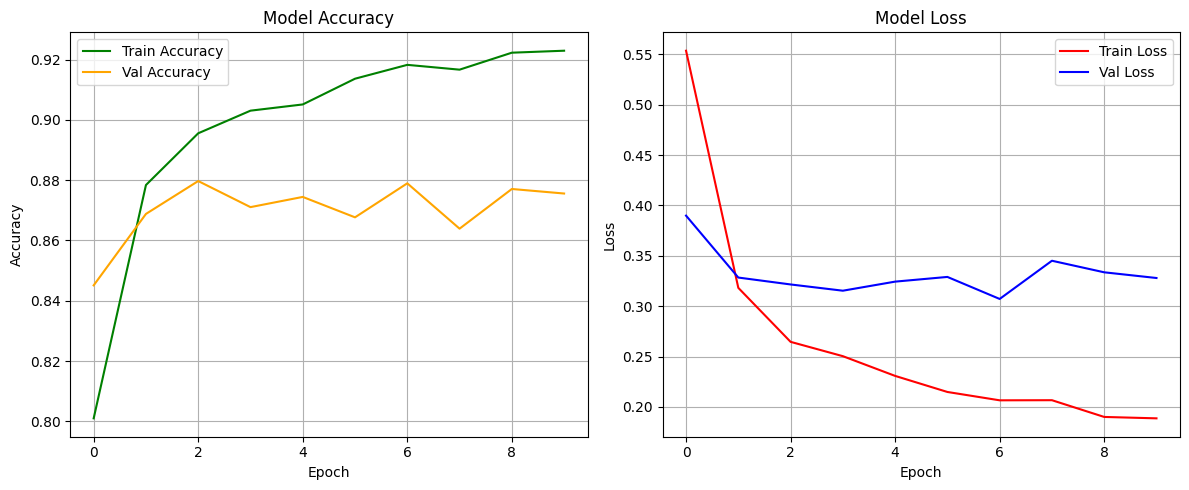

In [19]:
# 5. Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# 2. Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='blue')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
# 4. Save Keras Model
model.save("model/mobilenetv2_model.h5")

# 5. Convert to TFLite (Optimized for Mobile)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save .tflite model
with open("model/mobilenetv2_quant.tflite", "wb") as f:
    f.write(tflite_model)

print("Model training and TFLite conversion complete!")

INFO:tensorflow:Assets written to: C:\Users\piyus\AppData\Local\Temp\tmpx380apk2\assets


INFO:tensorflow:Assets written to: C:\Users\piyus\AppData\Local\Temp\tmpx380apk2\assets


Saved artifact at 'C:\Users\piyus\AppData\Local\Temp\tmpx380apk2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 17), dtype=tf.float32, name=None)
Captures:
  2268947834704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2268948572944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2268948573136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2268948571600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2268948572752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2268948574288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2268948574672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2268948575056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2268948574864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2268948571792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  